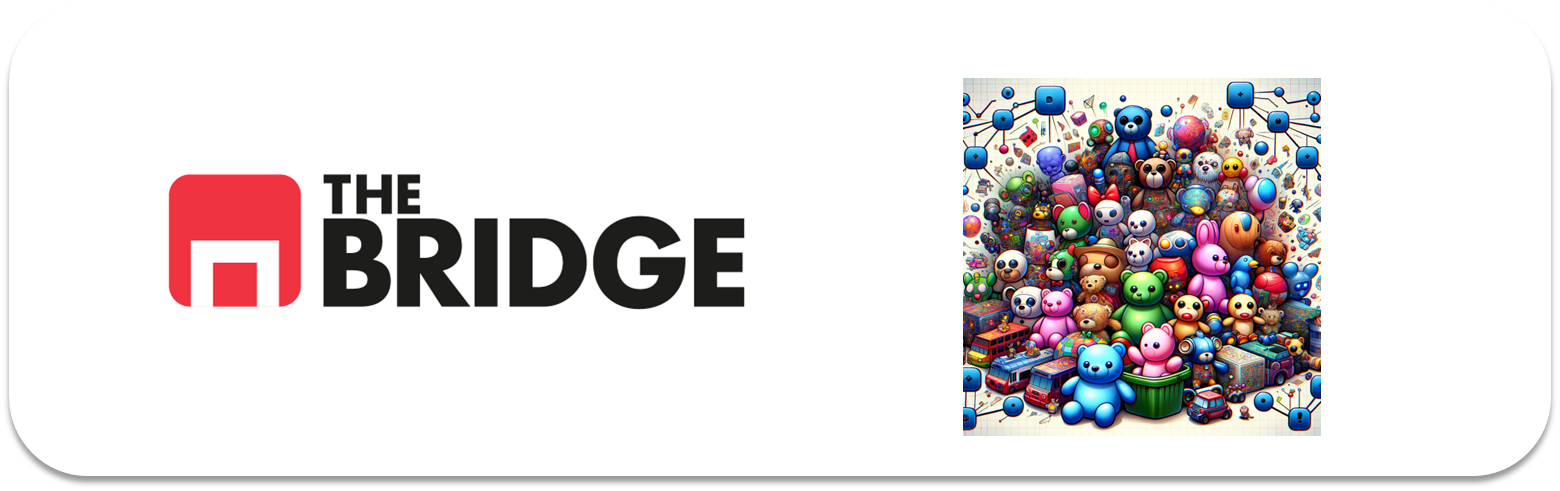

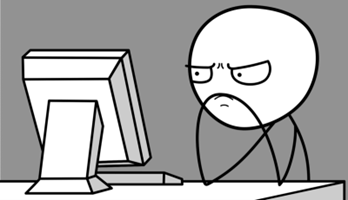

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [1]:
from sklearn.datasets import fetch_olivetti_faces

# Cargamos el dataset Olivetti Faces
olivetti_faces = fetch_olivetti_faces()

# Mostramos la descripción del dataset
print(olivetti_faces['DESCR'])


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Guillem\scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [3]:
# Cargamos el dataset
data = fetch_olivetti_faces()

# Mostramos  el target
print("Target (persona asociada a cada imagen):")
print(data['target'])

# Convierto las imágenes (features) en un dataframe
df = pd.DataFrame(data['data'])

# Añadimos la columna target al dataframe
df['target'] = data['target']

# Se reordenan aleatoriamente las filas del dataframe
df_random = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Finalmente, mostramos las primeras filas del dataframe aleatorizado
print(df_random.head())

Target (persona asociada a cada imagen):
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [6]:
# Dividimos inicialmente el dataset en train (80%) y (validation + test) (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=42)

# Ahora dividimos temp_df en validación (10%) y prueba (10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['target'], random_state=42)

# Imprimimos el número de muestras en cada conjunto
print(f"Train set: {len(train_df)} imágenes")
print(f"Validation set: {len(val_df)} imágenes")
print(f"Test set: {len(test_df)} imágenes")

Train set: 320 imágenes
Validation set: 40 imágenes
Test set: 40 imágenes


### #1.4

Crea los pares X,y para train, validation y test.

In [7]:
# Separar las características (X) y las etiquetas (y) para cada conjunto

# Para el conjunto de entrenamiento
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

# Para el conjunto de validación
X_val = val_df.drop(columns=['target'])
y_val = val_df['target']

# Para el conjunto de prueba
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

# Imprimir las formas de los conjuntos resultantes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (320, 4096), y_train shape: (320,)
X_val shape: (40, 4096), y_val shape: (40,)
X_test shape: (40, 4096), y_test shape: (40,)


Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [8]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

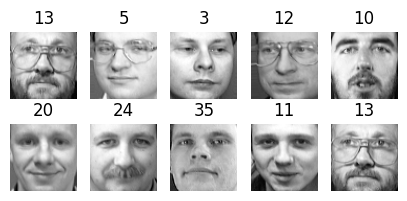

In [11]:
# Una vez ejecutada la función, la nombramos
plot_faces(X_train.iloc[:10].values, y_train.iloc[:10].values)


### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [12]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

222

### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [14]:
# Lista para almacenar los resultados de K y sus correspondientes scores de silueta
k_values = []
silhouette_scores = []

# Probamos K desde 5 hasta 150 en pasos de 5
for k in range(5, 151, 5):
    # Se inicializa KMeans con k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Se ajusta el modelo en los datos de entrenamiento reducidos con PCA
    kmeans.fit(X_train_pca)
    
    # Predecimos los clusters
    cluster_labels = kmeans.labels_
    
    # Calculamos el score de silueta
    score = silhouette_score(X_train_pca, cluster_labels)
    
    # Se añaden los resultados en las listas mencionadas al inicio
    k_values.append(k)
    silhouette_scores.append(score)
    
    print(f"K: {k}, Silhouette Score: {score:.4f}")

# Llegados aqui, buscamos el mejor score o el valor de K con el mejor score de silueta
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)

print(f"\nEl mejor número de clusters (k) es: {best_k} con un score de silueta de: {best_score:.4f}")


K: 5, Silhouette Score: 0.0908
K: 10, Silhouette Score: 0.0980
K: 15, Silhouette Score: 0.0864
K: 20, Silhouette Score: 0.0977
K: 25, Silhouette Score: 0.1186
K: 30, Silhouette Score: 0.1235
K: 35, Silhouette Score: 0.1279
K: 40, Silhouette Score: 0.1332
K: 45, Silhouette Score: 0.1551
K: 50, Silhouette Score: 0.1664
K: 55, Silhouette Score: 0.1622
K: 60, Silhouette Score: 0.1688
K: 65, Silhouette Score: 0.1753
K: 70, Silhouette Score: 0.1797
K: 75, Silhouette Score: 0.1863
K: 80, Silhouette Score: 0.2007
K: 85, Silhouette Score: 0.1973
K: 90, Silhouette Score: 0.1984
K: 95, Silhouette Score: 0.1933
K: 100, Silhouette Score: 0.1999
K: 105, Silhouette Score: 0.1989
K: 110, Silhouette Score: 0.1917
K: 115, Silhouette Score: 0.1954
K: 120, Silhouette Score: 0.1907
K: 125, Silhouette Score: 0.1920
K: 130, Silhouette Score: 0.1946
K: 135, Silhouette Score: 0.1970
K: 140, Silhouette Score: 0.1998
K: 145, Silhouette Score: 0.2012
K: 150, Silhouette Score: 0.2000

El mejor número de clusters (

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

K: 5, Inercia: 17885.2188
K: 10, Inercia: 15068.9766
K: 15, Inercia: 13855.5469
K: 20, Inercia: 12768.6240
K: 25, Inercia: 11576.9219
K: 30, Inercia: 10768.8877
K: 35, Inercia: 10123.6592
K: 40, Inercia: 9556.4629
K: 45, Inercia: 8748.5781
K: 50, Inercia: 8142.6133
K: 55, Inercia: 7775.2236
K: 60, Inercia: 7288.0771
K: 65, Inercia: 6879.9097
K: 70, Inercia: 6511.6553
K: 75, Inercia: 6140.3003
K: 80, Inercia: 5711.6865
K: 85, Inercia: 5475.6582
K: 90, Inercia: 5198.1748
K: 95, Inercia: 4993.4238
K: 100, Inercia: 4701.7222
K: 105, Inercia: 4483.8643
K: 110, Inercia: 4297.8652
K: 115, Inercia: 4064.9878
K: 120, Inercia: 3882.7397
K: 125, Inercia: 3688.6714
K: 130, Inercia: 3462.4290
K: 135, Inercia: 3257.1904
K: 140, Inercia: 3053.0098
K: 145, Inercia: 2871.1045
K: 150, Inercia: 2743.4727


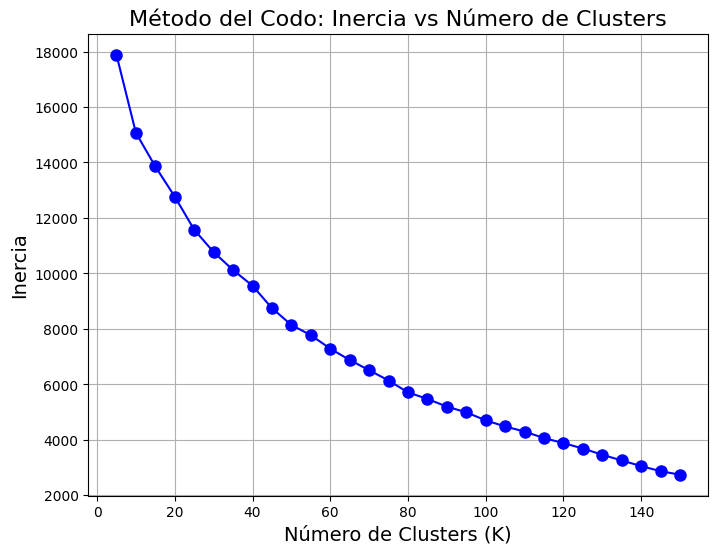

In [15]:
# Lista para almacenar los valores de K y la inercia correspondiente
inertia_values = []
k_values = range(5, 151, 5)

# Probar K desde 5 hasta 150 en pasos de 5
for k in k_values:
    # Inicializar KMeans con k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Ajustar el modelo en los datos de entrenamiento reducidos con PCA
    kmeans.fit(X_train_pca)
    
    # Guardar la inercia (distancia al cuadrado de los puntos a sus centroides)
    inertia_values.append(kmeans.inertia_)
    
    print(f"K: {k}, Inercia: {kmeans.inertia_:.4f}")

# Graficar la inercia para cada valor de K
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, 'bo-', markersize=8)
plt.xlabel('Número de Clusters (K)', fontsize=14)
plt.ylabel('Inercia', fontsize=14)
plt.title('Método del Codo: Inercia vs Número de Clusters', fontsize=16)
plt.grid(True)
plt.show()


### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [17]:
from sklearn.cluster import KMeans

# Utilizamos el valor de K obtenido previamente con el mejor score de silueta
best_k = best_k  #Calculado tras el codigo de score de silueta

# Inicializamos y entrenamos el modelo de KMeans con el mejor K
best_model = KMeans(n_clusters=best_k, random_state=42)

# Ajustar el modelo al conjunto de datos de entrenamiento (reducido con PCA)
best_model.fit(X_train_pca)

# Ahora `best_model` tiene el modelo K-Means entrenado con el número óptimo de clusters


KMeans(n_clusters=145, random_state=42)

### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?


Mostrando imágenes del Cluster 0:


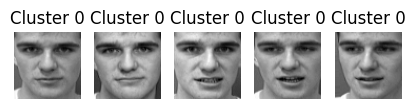


Mostrando imágenes del Cluster 1:


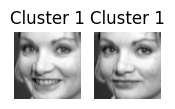


Mostrando imágenes del Cluster 2:


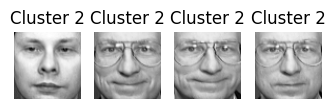


Mostrando imágenes del Cluster 3:


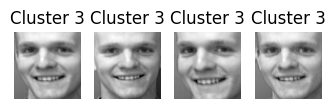


Mostrando imágenes del Cluster 4:


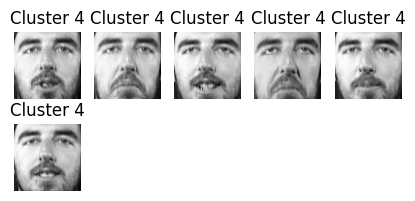


Mostrando imágenes del Cluster 5:


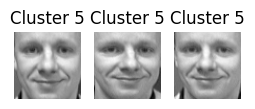


Mostrando imágenes del Cluster 6:


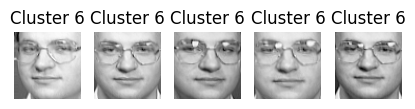


Mostrando imágenes del Cluster 7:


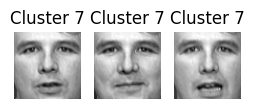


Mostrando imágenes del Cluster 8:


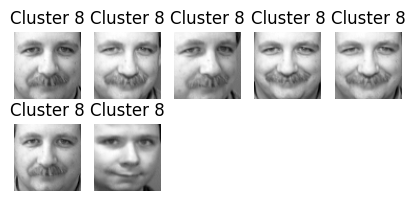


Mostrando imágenes del Cluster 9:


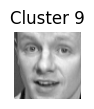

In [19]:
# Función para visualizar las caras (está cogiendo las originales)
def plot_faces_per_cluster(X_original, labels, cluster_number, n_faces=10):
    # Selecciona las imágenes que pertenecen al cluster actual
    cluster_indices = np.where(labels == cluster_number)[0]
    
    # Si hay menos de n_faces en el cluster, ajusta el número a la cantidad disponible
    n_faces = min(n_faces, len(cluster_indices))
    
    # Selecciona las primeras n_faces imágenes del cluster
    selected_faces = X_original.iloc[cluster_indices[:n_faces]].values
    selected_labels = [f"Cluster {cluster_number}"] * n_faces
    
    # Muéstrame las caras
    plot_faces(selected_faces, selected_labels)

# Asignamos etiquetas de clusters a las imágenes originales
cluster_labels = best_model.labels_

# Recorrer y visualizar los primeros 10 clusters con la función creada
for cluster_num in range(10):
    print(f"\nMostrando imágenes del Cluster {cluster_num}:")
    plot_faces_per_cluster(X_train, cluster_labels, cluster_number=cluster_num, n_faces=10)


## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [21]:
# 1. Carga del conjunto de datos de caras Olivetti
data = fetch_olivetti_faces()
X = data.data  # Características (pixeles de las imágenes)
y = data.target  # Etiquetas (identidad de la persona)

# 2. Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Entrenar el modelo
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

# 4. Evaluar el modelo
y_pred = model.predict(X_val)

# Imprimir resultados de la evaluación
print("Matriz de confusión:\n", confusion_matrix(y_val, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_val, y_pred))


Matriz de confusión:
 [[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.67      1.00      0.80         2
          13       1.00      1.00      1.00         2
          14       

### He buscado la forma de pintar la matriz de confusión con seaborn y un heatmap pero me da unos resultados muy poco visibles ni presentables

### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [26]:
# Volvemos a cargar los datos del dataset
data = fetch_olivetti_faces()
X = data.data  # Características (pixeles de las imágenes)
y = data.target  # Etiquetas (identidad de la persona)

# Dividimos la muestra entre train y test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenamos el modelo K-means
n_clusters = 10  #son las clases que hay en el conjunto de datos
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

# Realizo una transformación de los datos 
X_train_reduced = kmeans.transform(X_train) 
X_val_reduced = kmeans.transform(X_val)

# Entrenamos un modelo de Random Forest sobre el conjunto reducido
model_rf = RandomForestClassifier(n_estimators=150, random_state=42)
model_rf.fit(X_train_reduced, y_train)

# Evaluo el modelo y lo cruzo contra el dataset de validación 
y_pred_rf = model_rf.predict(X_val_reduced)

# Imprimir resultados de la evaluación
print("Matriz de confusión:\n", confusion_matrix(y_val, y_pred_rf))
print("\nReporte de clasificación:\n", classification_report(y_val, y_pred_rf))

Matriz de confusión:
 [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.50      0.50         2
           2       0.33      0.50      0.40         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.67      1.00      0.80         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       0.67      1.00      0.80         2
           9       0.00      0.00      0.00         2
          10       1.00      0.50      0.67         2
          11       0.00      0.00      0.00         2
          12       0.50      1.00      0.67         2
          13       0.50      0.50      0.50         2
          14       

c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)